In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sensor1.csv to sensor1.csv


In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
# Load the model (if not already loaded)
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the data
data = pd.read_csv('sensor1.csv')

# Preprocess the data
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

data.drop(['CO2', 'PM10', 'PM2.5', 'Temperature', 'TVOC'], axis=1, inplace=True)
data['Humidity'] = data['Humidity'].str.split().str[0].astype(float)  # Extract Humidity values

rolling_window_size = 10 # This is the number of points to include in the window
data['Humidity'] = data['Humidity'].rolling(window=rolling_window_size).mean()

# Drop rows with NaN values
data.dropna(inplace=True)

print(data.head())

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Normalize the entire dataset

# Define window size for sequences
window_size = 20

# Prepare sequences
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predicting only Humidity, hence [0]
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, window_size)

# Split the data into training and testing sets
split_ratio = 0.8  # 80% for training, 20% for testing
total_sequences = len(X)  # Total number of sequences prepared from your dataset
split_index = int(total_sequences * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

                     Humidity
Time                         
2024-03-13 13:00:00     77.73
2024-03-13 12:00:00     77.76
2024-03-13 11:00:00     77.77
2024-03-13 10:00:00     77.78
2024-03-13 09:00:00     77.82


In [ ]:
# Build the RNN model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),  # Adding dropout for regularization
    LSTM(units=64),
    Dropout(0.2),  # Adding dropout for regularization
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)


Epoch 1/20
14/14 [==============================] - 5s 90ms/step - loss: 0.0521 - val_loss: 0.0339
Epoch 2/20
14/14 [==============================] - 0s 26ms/step - loss: 0.0187 - val_loss: 0.0246
Epoch 3/20
14/14 [==============================] - 0s 25ms/step - loss: 0.0152 - val_loss: 0.0224
Epoch 4/20
14/14 [==============================] - 0s 26ms/step - loss: 0.0141 - val_loss: 0.0206
Epoch 5/20
14/14 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.0195
Epoch 6/20
14/14 [==============================] - 0s 24ms/step - loss: 0.0121 - val_loss: 0.0185
Epoch 7/20
14/14 [==============================] - 0s 26ms/step - loss: 0.0111 - val_loss: 0.0170
Epoch 8/20
14/14 [==============================] - 0s 25ms/step - loss: 0.0099 - val_loss: 0.0158
Epoch 9/20
14/14 [==============================] - 0s 24ms/step - loss: 0.0091 - val_loss: 0.0145
Epoch 10/20
14/14 [==============================] - 0s 28ms/step - loss: 0.0090 - val_loss: 0.0148
Epoch 11/

In [ ]:
y_pred = model.predict(X_test)
# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


5/5 [==============================] - 1s 7ms/step


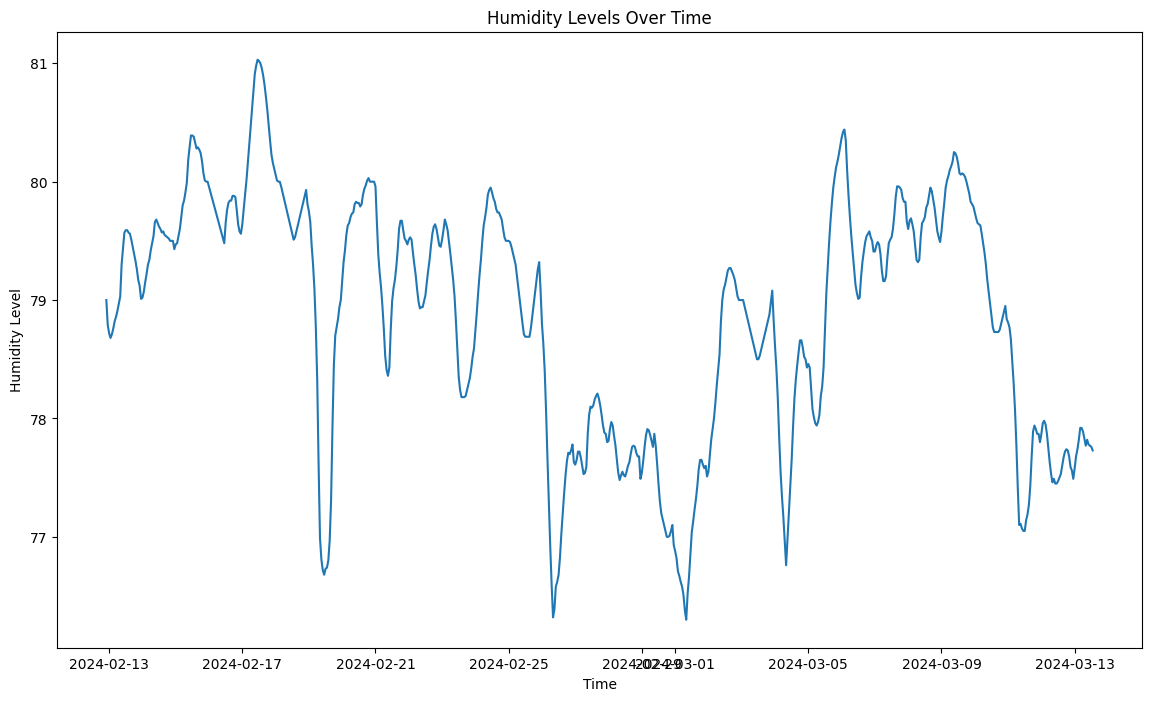

In [ ]:
# Visualize the input data
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

plt.plot(data.index, data['Humidity'])
plt.xlabel('Time')
plt.ylabel('Humidity Level')
plt.title('Humidity Levels Over Time')
plt.show()

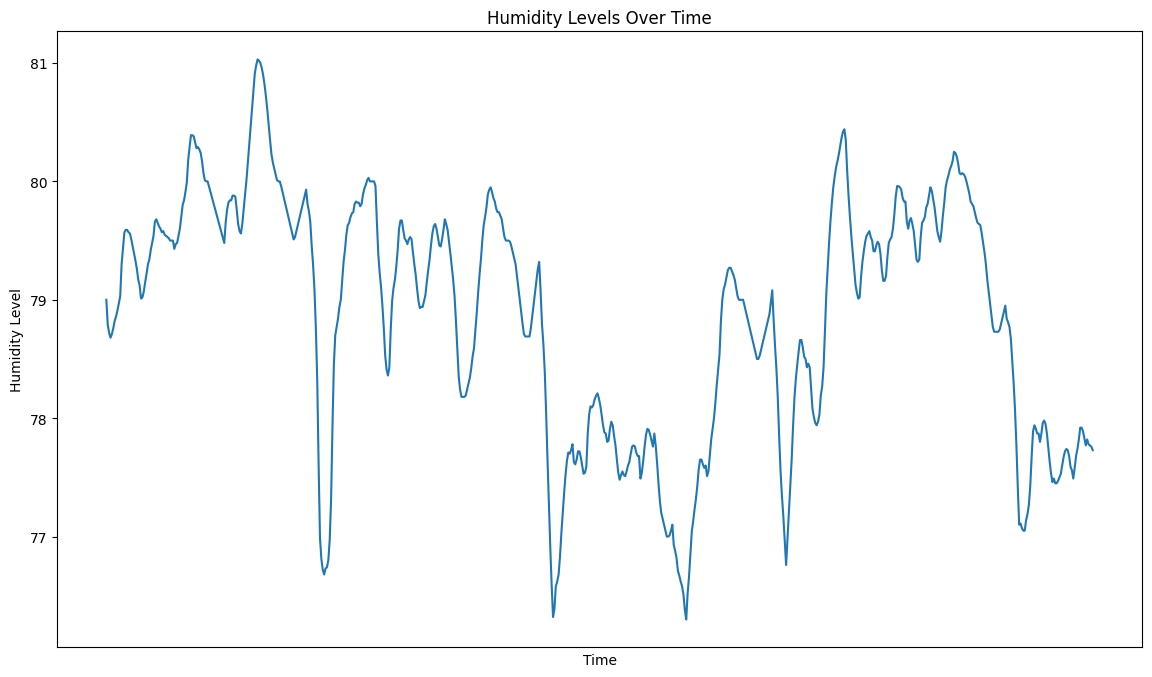

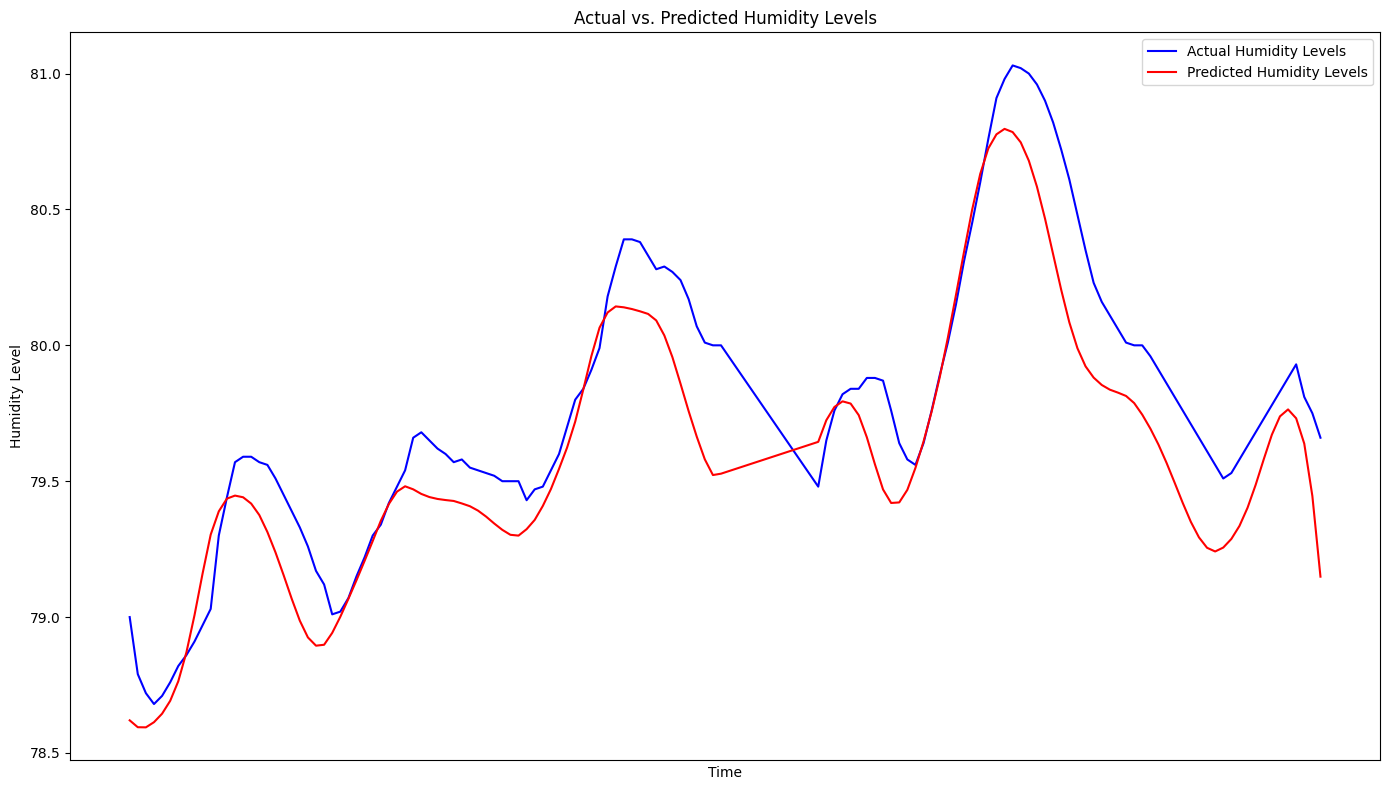

In [ ]:
# Visualize the input data
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Humidity'])
plt.xlabel('Time')
plt.ylabel('Humidity Level')
plt.title('Humidity Levels Over Time')

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(data.index[0], data.index[-1], freq='H'), rotation=45)

plt.show()

# Visualize the predictions
plt.figure(figsize=(14, 8))

actual_dates = data.index[-len(y_test_actual):]  # This fetches the dates for the test segment

plt.plot(actual_dates, y_test_actual, label='Actual Humidity Levels', color='blue')
plt.plot(actual_dates, y_pred_actual, label='Predicted Humidity Levels', color='red')

plt.xlabel('Time')
plt.ylabel('Humidity Level')
plt.title('Actual vs. Predicted Humidity Levels')
plt.legend()

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(actual_dates[0], actual_dates[-1], freq='H'), rotation=45)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = sqrt(mean_squared_error(y_test_actual, y_pred_actual))  # As calculated previously
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test MAPE: {mape}%')
print(f'Test R-Squared: {r2}')


Test MAE: 0.194993357414745
Test RMSE: 0.23810668890222325
Test MAPE: 0.2440510565173173%
Test R-Squared: 0.7886496363253525


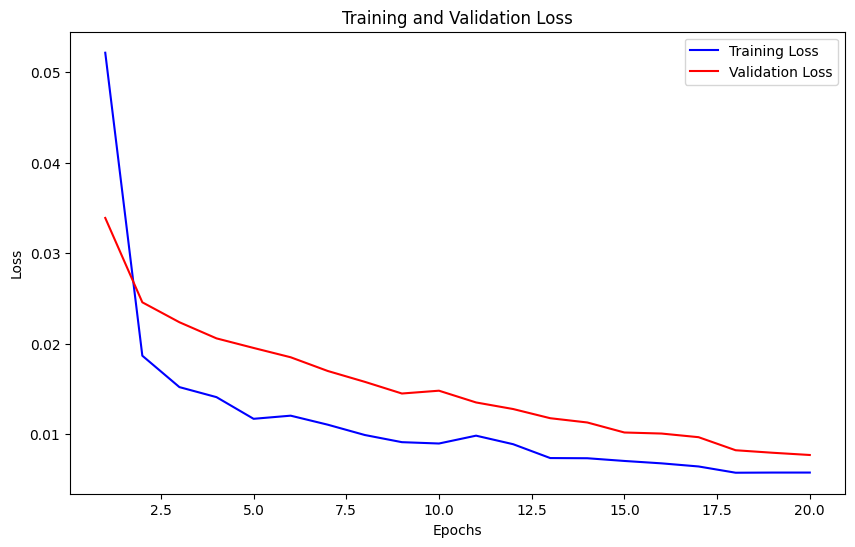

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Assuming you have an equal number of epochs for training and validation
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Hyperparameters Tuning

In [ ]:
!pip install keras
!pip install scikeras

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasRegressor

# def create_model():
#     model = Sequential([
#         LSTM(64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
#         Dropout(0.2),
#         LSTM(64),
#         Dropout(0.2),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# model = KerasRegressor(build_fn=create_model, verbose=0)

# # define the grid search parameters
# batch_size = [24, 32, 64, 128]
# epochs = [20, 50, 65]
# param_grid = dict(batch_size=batch_size, epochs=epochs)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


**Implementation using optimal parameters**

In [ ]:
# Build the RNN model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),  # Adding dropout for regularization
    LSTM(units=64),
    Dropout(0.2),  # Adding dropout for regularization
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=65,
    batch_size=24,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)


Epoch 1/65
19/19 [==============================] - 6s 115ms/step - loss: 0.0455 - val_loss: 0.0324
Epoch 2/65
19/19 [==============================] - 0s 23ms/step - loss: 0.0175 - val_loss: 0.0247
Epoch 3/65
19/19 [==============================] - 0s 24ms/step - loss: 0.0136 - val_loss: 0.0206
Epoch 4/65
19/19 [==============================] - 0s 23ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 5/65
19/19 [==============================] - 0s 22ms/step - loss: 0.0121 - val_loss: 0.0185
Epoch 6/65
19/19 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0183
Epoch 7/65
19/19 [==============================] - 1s 32ms/step - loss: 0.0108 - val_loss: 0.0178
Epoch 8/65
19/19 [==============================] - 1s 42ms/step - loss: 0.0102 - val_loss: 0.0146
Epoch 9/65
19/19 [==============================] - 1s 51ms/step - loss: 0.0094 - val_loss: 0.0135
Epoch 10/65
19/19 [==============================] - 1s 48ms/step - loss: 0.0078 - val_loss: 0.0146
Epoch 11

In [ ]:
y_pred = model.predict(X_test)
# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

5/5 [==============================] - 1s 7ms/step


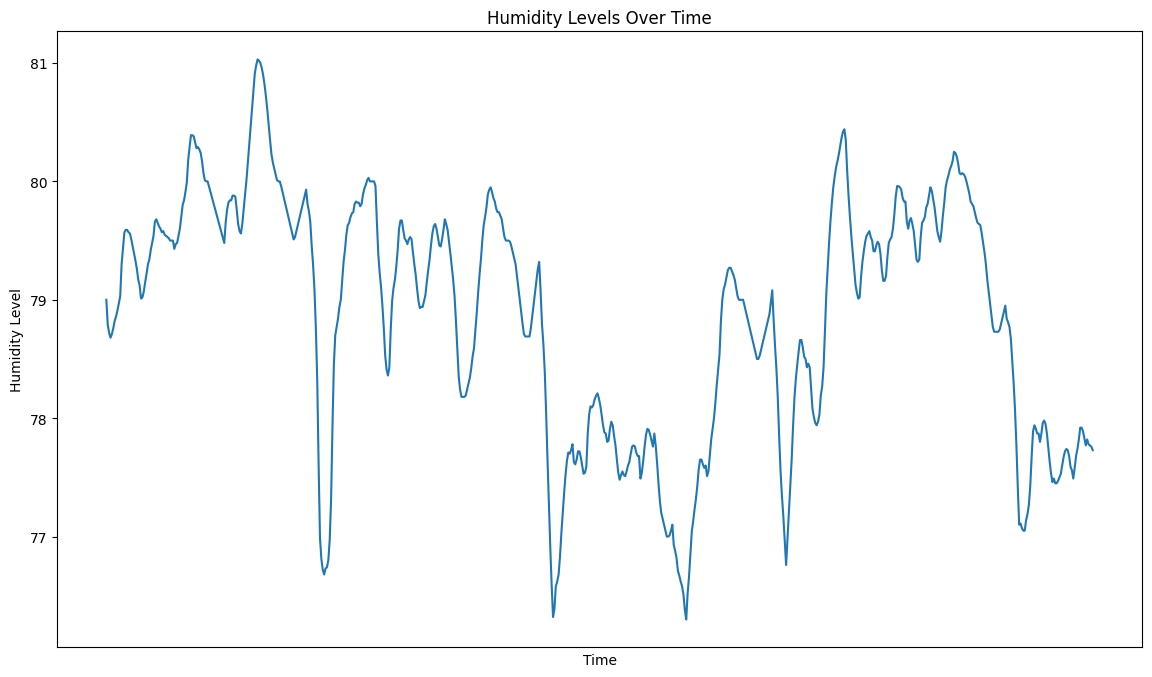

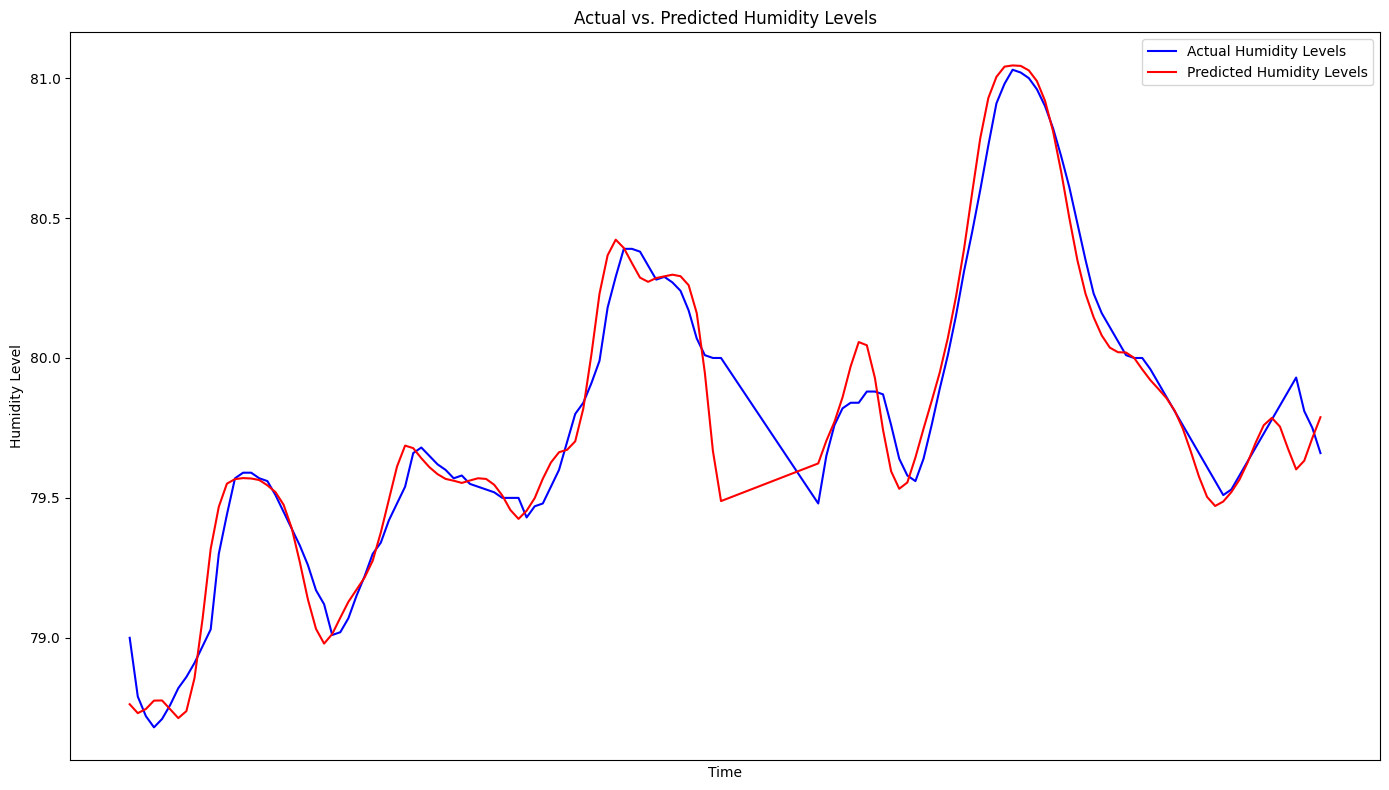

In [ ]:
# Visualize the input data
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Humidity'])
plt.xlabel('Time')
plt.ylabel('Humidity Level')
plt.title('Humidity Levels Over Time')

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(data.index[0], data.index[-1], freq='H'), rotation=45)

plt.show()

# Visualize the predictions
plt.figure(figsize=(14, 8))

actual_dates = data.index[-len(y_test_actual):]

plt.plot(actual_dates, y_test_actual, label='Actual Humidity Levels', color='blue')
plt.plot(actual_dates, y_pred_actual, label='Predicted Humidity Levels', color='red')

plt.xlabel('Time')
plt.ylabel('Humidity Level')
plt.title('Actual vs. Predicted Humidity Levels')
plt.legend()

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(actual_dates[0], actual_dates[-1], freq='H'), rotation=45)

plt.tight_layout()

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test MAPE: {mape}%')
print(f'Test R-Squared: {r2}')

Test MAE: 0.07465592655822278
Test RMSE: 0.10639755522929911
Test MAPE: 0.09358060931292053%
Test R-Squared: 0.957798964661326


### Plotting Training and Validation Loss

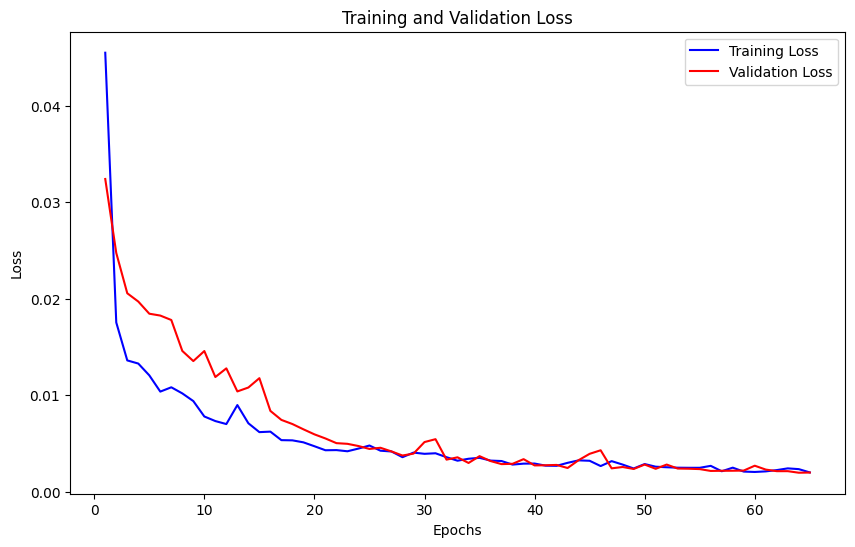

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Assuming you have an equal number of epochs for training and validation
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()